In [1]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import pmdarima as pm
import pandas as pd
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt

from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf

import math
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=20,6

### Funções

In [50]:
def apl_sarima(df_st, m):
    
    df_train = df_st.iloc[:int(len(df_st) * 0.8)]
    df_test = df_st.iloc[int(len(df_st) * 0.8):]

    stepwise= pm.auto_arima(df_train,
                            max_p=22, max_q=18, max_d=2,
                            max_P=22, max_D=2, max_Q=18, max_order=5,
                            m = m,
                            seasonal=True,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True )

    stepwise.summary()
    stepwise.plot_diagnostics();
   
    #MÉTRICAS DO TREINO
    print('Métricas treino: SARIMA')
    print('r2' ,r2_score(stepwise.predict_in_sample(),df_train))
    print('mse' ,mean_squared_error(stepwise.predict_in_sample(), df_train))
    print('mae', mean_absolute_error(stepwise.predict_in_sample(), df_train))
    print('MAPE', mean_absolute_percentage_error(stepwise.predict_in_sample(), df_train))


    fig, ax = plt.subplots()
    ax.plot(stepwise.predict_in_sample(), label='pred')
    ax.plot(df_train, label='true')
    plt.title('AUTOARIMA TRAIN MODEL')
    plt.legend()
    plt.show()

    #PREVENDO O TESTE
    previsao = stepwise.predict(len(df_test))
    previsao=pd.DataFrame(previsao)
    previsao['index'] = df_test.index
    previsao = previsao.set_index('index')

    #MÉTRICAS DO TESTE
    
    print('MÉTRICAS TESTE SARIMA')
    print('R2' ,r2_score(df_test, previsao))
    print('MSE' , mean_squared_error(df_test, previsao))
    print('RMSE', math.sqrt(mean_squared_error(df_test, previsao)))
    print('MAE', mean_absolute_error(df_test, previsao))

    fig, ax = plt.subplots()
    ax.plot(previsao, label='pred')
    ax.plot(df_test, label='true')
    plt.title('SARIMA TEST MODEL')
    plt.legend()
    plt.show()
    
    #GRÁFICO CONCATENADO DO TREINO E DO PREVISTO NO TESTE
    pd.concat([df_st,previsao],
            axis=1).plot(linewidth=2,
                        figsize=(20,7),
                        color=['g','r'])
    plt.legend(['Real','Previsões'], fontsize=15)
    plt.xlabel('Período', size=15)
    plt.title('Previsões X Real',size=15)
    plt.show();
    



### Lendo o Dataset

In [3]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')
df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

C:\Users\gabri\AppData\Local\Temp\ipykernel_16160\3930293311.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


### Testando o Modelo Manualmente

In [4]:
df_train = df_st.iloc[:int(len(df_st) * 0.8)]
df_test = df_st.iloc[int(len(df_st) * 0.8):]

In [38]:
stepwise= pm.auto_arima(df_st,
                        #start_p=0, start_q=0,
                        #d=0,
                        max_p=22, max_q=18, max_d=2,
                        #start_P=0, start_Q=0,
                        #D=0,
                        max_P=22, max_D=2, max_Q=18, #max_order=5,
                        m = 7,
                        seasonal=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=12167.235, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12848.767, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12255.807, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12488.045, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12846.770, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=12377.074, Time=1.40 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=12177.416, Time=2.45 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=12185.008, Time=2.64 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=12556.015, Time=0.59 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=12339.927, Time=2.46 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=12189.131, Time=2.96 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   :

In [39]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  821
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -6042.227
Date:                             Sun, 13 Nov 2022   AIC                          12094.454
Time:                                     21:11:34   BIC                          12118.000
Sample:                                          0   HQIC                         12103.488
                                             - 821                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2248      0.016    -14.406      0.000      -0.255      -0.194
ma.L2         -0.1398      0.017     -8.219      0.000      -0.173      -0.106
ar.S.L7        0.9777      0.008    124.786      0.000       0.962       0.993
ma.S.L7       -0.7626      0.017    -44.440      0.000      -0.796      -0.729
sigma2      1.456e+05   3151.204     46.211      0.000    1.39e+05    1.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              4364.07
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               3.42   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

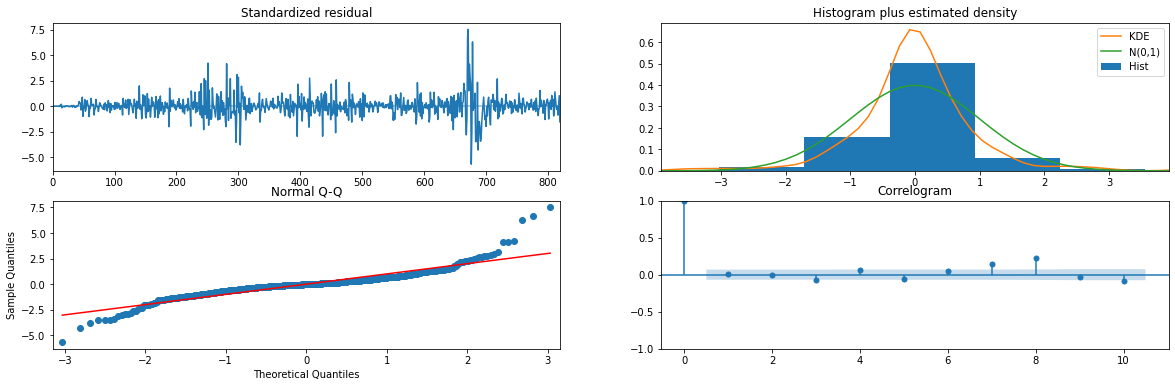

In [40]:
stepwise.plot_diagnostics();

In [41]:
stepwise.fit(df_train)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

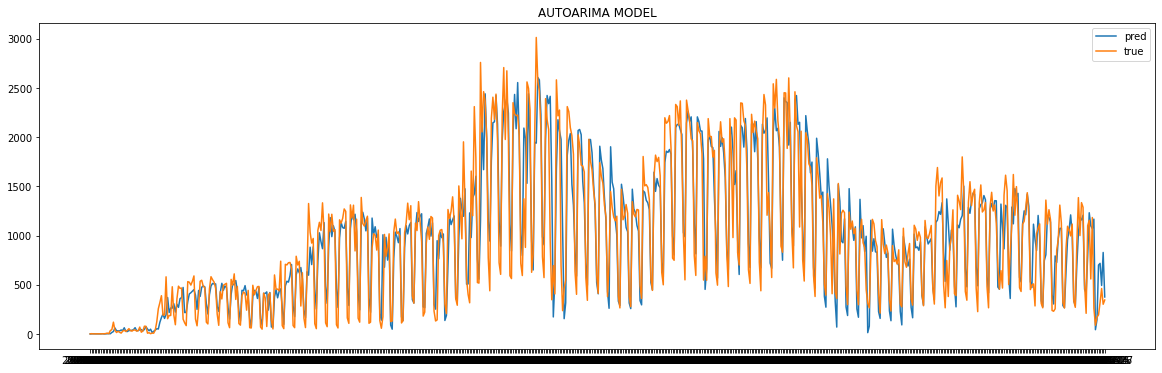

In [49]:
fig, ax = plt.subplots()
ax.plot(stepwise.predict_in_sample(), label='pred')
ax.plot(df_train, label='true')
plt.title('AUTOARIMA MODEL')
plt.legend()
plt.show()

In [43]:
print('SARIMA model Results')
print('r2' ,r2_score(stepwise.predict_in_sample(),df_train))
print('mse' ,mean_squared_error(stepwise.predict_in_sample(), df_train))
print('mae', mean_absolute_error(stepwise.predict_in_sample(), df_train))
print('MAPE', mean_absolute_percentage_error(stepwise.predict_in_sample(), df_train))

SARIMA model Results
r2 0.8155277674273147
mse 80693.39538921307
mae 188.22494269748762
MAPE 6865243334406.605


In [44]:
previsao = stepwise.predict(len(df_test))
previsao=pd.DataFrame(previsao)
previsao['index'] = df_test.index
previsao = previsao.set_index('index')

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [45]:
print('SARIMA model Results')
print('R2' ,r2_score(df_test, previsao))
print('MSE' , mean_squared_error(df_test, previsao))
print('RMSE', math.sqrt(mean_squared_error(df_test, previsao)))
print('MAE', mean_absolute_error(df_test, previsao))

SARIMA model Results
R2 -1.3610553301320447
MSE 8609388.64691178
RMSE 2934.1759740874063
MAE 2441.936935350739


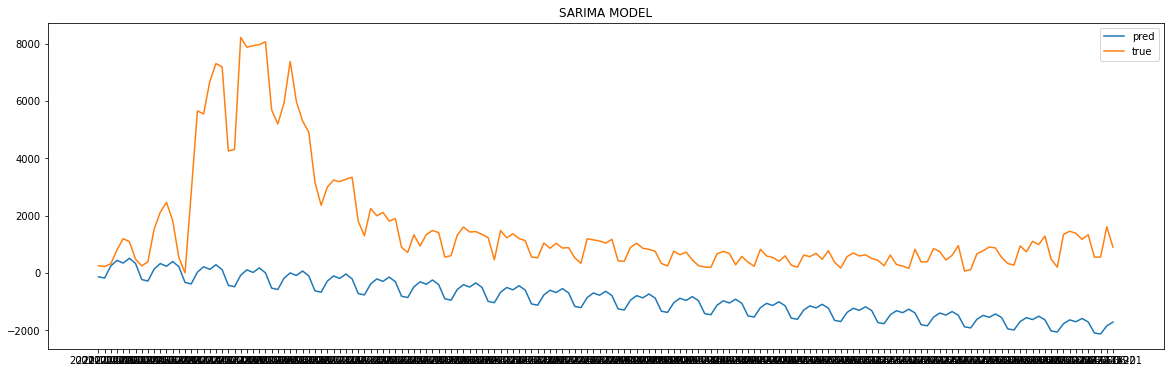

In [46]:
fig, ax = plt.subplots()
ax.plot(previsao, label='pred')
ax.plot(df_test, label='true')
plt.title('SARIMA MODEL')
plt.legend()
plt.show()

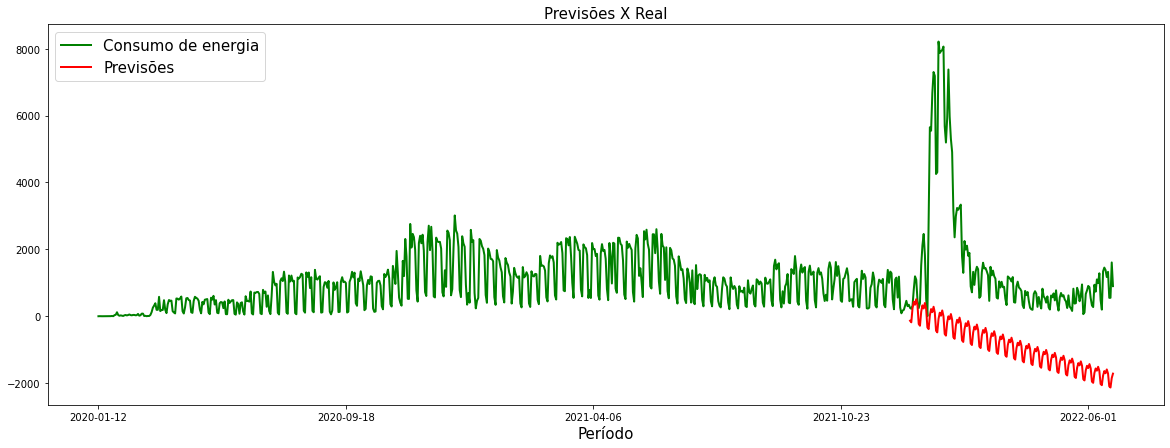

In [48]:
pd.concat([df_st,previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Consumo de energia','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();

### APLICANDO MODELO PARA SAZONALIDADE DE 15 DIAS

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[15] intercept   : AIC=9795.076, Time=2.25 sec
 ARIMA(0,1,0)(0,0,0)[15] intercept   : AIC=10202.971, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[15] intercept   : AIC=10202.023, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[15] intercept   : AIC=10013.661, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[15]             : AIC=10200.972, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[15] intercept   : AIC=9818.219, Time=1.96 sec
 ARIMA(2,1,2)(1,0,0)[15] intercept   : AIC=9826.664, Time=1.71 sec
 ARIMA(2,1,2)(2,0,1)[15] intercept   : AIC=9763.192, Time=6.95 sec
 ARIMA(2,1,2)(2,0,0)[15] intercept   : AIC=inf, Time=5.01 sec
 ARIMA(2,1,2)(3,0,1)[15] intercept   : AIC=9826.637, Time=12.04 sec
 ARIMA(2,1,2)(2,0,2)[15] intercept   : AIC=inf, Time=7.08 sec
 ARIMA(2,1,2)(1,0,2)[15] intercept   : AIC=9773.080, Time=6.87 sec
 ARIMA(2,1,2)(3,0,0)[15] intercept   : AIC=9762.884, Time=12.12 sec
 ARIMA(2,1,2)(4,0,0)[15] intercept   : AIC=9834.680, Time=23.70 sec
 ARIMA(2,1,2)(4,0,1)[1

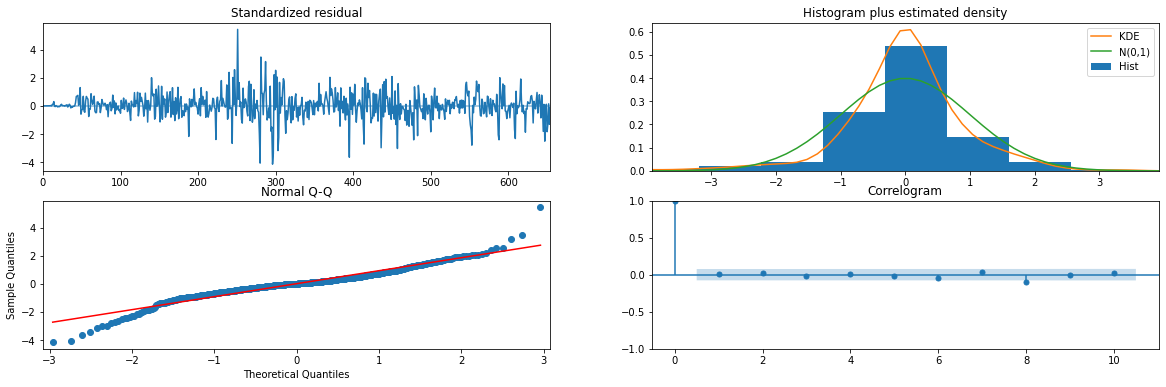

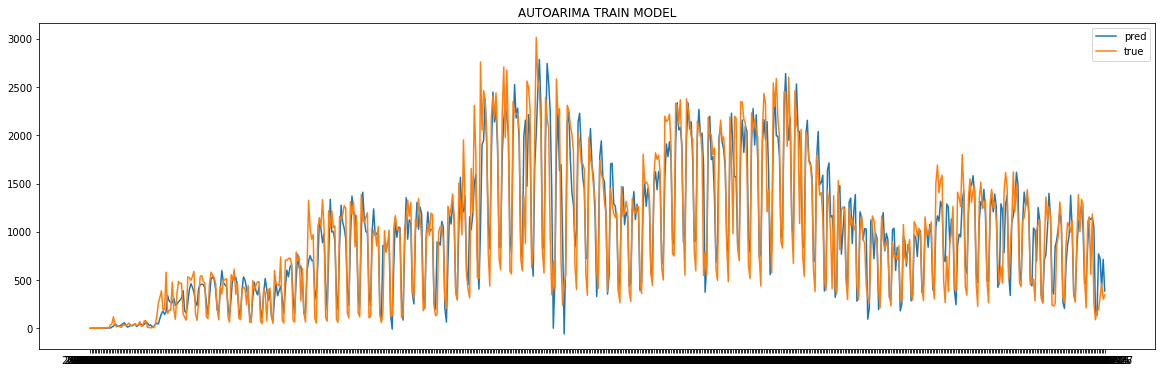

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MÉTRICAS TESTE SARIMA
R2 -0.3743313340594052
MSE 5011383.017391819
RMSE 2238.611850543059
MAE 1234.7157347040638


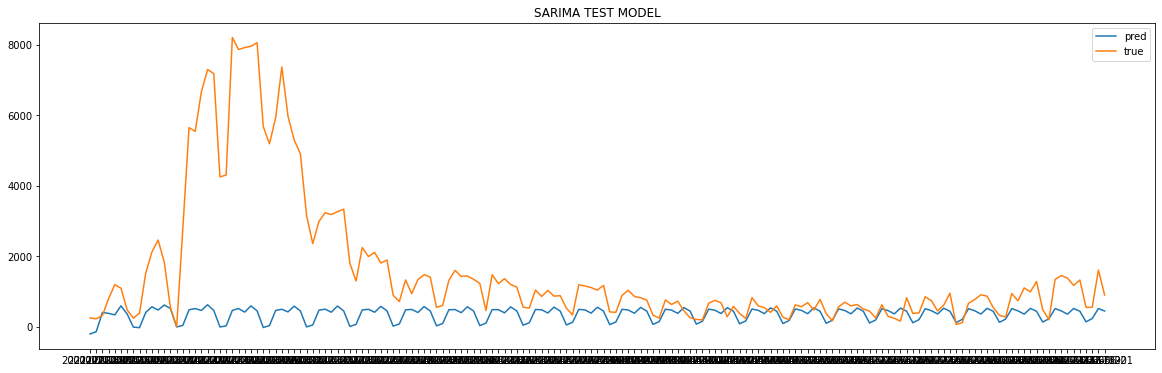

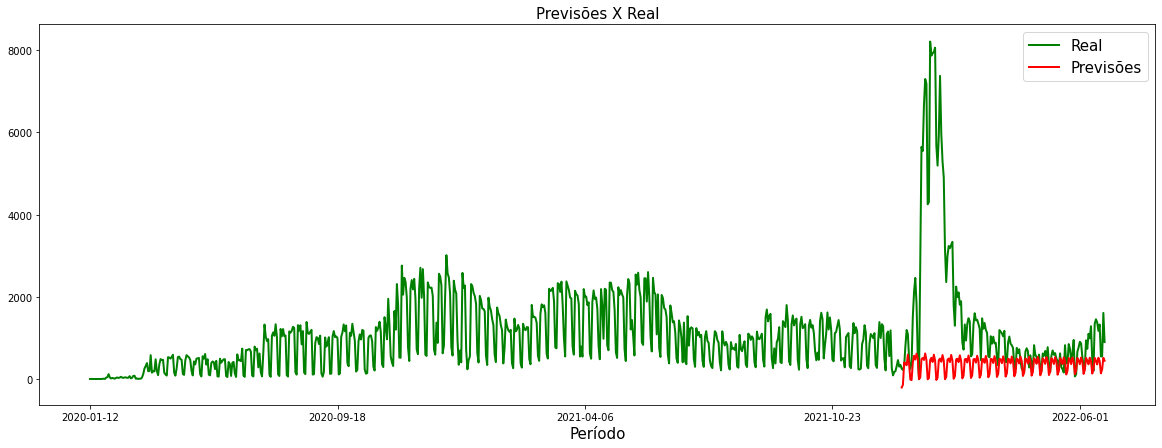

In [51]:
apl_sarima(df_st, 15)

In [52]:
apl_sarima(df_st, 20)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=9777.987, Time=6.14 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=10202.971, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=10125.145, Time=1.18 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=9968.061, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=10200.972, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=9781.623, Time=5.62 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=inf, Time=4.89 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=inf, Time=19.74 sec
 ARIMA(2,1,2)(1,0,2)[30] intercept   : AIC=inf, Time=21.25 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=9830.047, Time=0.59 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=9782.898, Time=18.62 sec
 ARIMA(2,1,2)(2,0,0)[30] intercept   : AIC=9777.792, Time=21.91 sec
 ARIMA(2,1,2)(3,0,0)[30] intercept   : AIC=9777.193, Time=89.48 sec
 ARIMA(2,1,2)(4,0,0)[30] intercept   : AIC=9744.876, Time=157.40 sec
 ARIMA(2,1,2)(5,0,0)[30]